# Medications Compliance workbook

This workbook uses medication order and statements tables from the NEL primary care data to analyse medications compliance by expolring methods of proportion of days covered (PDC)

See paper https://joppp.biomedcentral.com/articles/10.1186/s40545-021-00385-w

Please check and install requirements.txt before proceeding


## Import required packages/modules

In [196]:
import matplotlib.pyplot as plt
import pandas as pd
import re
from dotenv import load_dotenv
from tableone import TableOne

from phmlondon.snow_utils import SnowflakeConnection

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 100)

## CONFIG and FUNCTIONS

In [197]:
def get_top_n_classes(df, column_name, n=10):
    """
    Get the top n most frequent values in a specified column of the dataframe.

    Args:
        df (pd.DataFrame): The dataframe containing the data.
        column_name (str): The name of the column to analyze.
        n (int): The number of top values to return. Default is 10.

    Returns:
        pd.Series: A series containing the top n most frequent values and their counts.
    """
    return df[column_name].value_counts().head(n)

def plot_top_classes(class_counts):
    """
    Plot the top classes in a bar graph.

    Args:
        class_counts (pd.Series): A series containing the class counts.
    """
    plt.figure(figsize=(10, 6))
    class_counts.plot(kind='bar', color='skyblue')

    # Set the title and labels
    plt.title('Top Most Frequent Classes', fontsize=16)
    plt.xlabel('Class', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)

    # Rotate x-axis labels for readability
    plt.xticks(rotation=45, ha='right')

    # Adjust layout to fit everything
    plt.tight_layout()

    # Display the plot
    plt.show()

##def calculate_duration():

   ## """Cleans the dose column to get the frequncy of medications per day, then
   ##calcutates duration from dose and quantity"""

 ##   dose*quanitity!!


def clean_dose(df):
    def process_dose(dose):
        if not isinstance(dose, str):  # Handle cases where dose is NaN or not a string
            return None

        dose = dose.lower().strip()  # Convert to lowercase and remove extra spaces

        # Define mappings for standard frequency terms
        dose_mappings = {
            "bd": 2,  # Twice a day
            "tds": 3,  # Three times a day
            "qds": 4,  # Four times a day
            "once daily": 1,
            "take one": 1,
            "take 1":1,
            "one":1,
            "two":2,
            "take 2":2,
            "take two":2,
            "twice a day": 2,
            "three times a day": 3,
            "four times a day": 4,
            "prn": None  # As needed - unclear frequency
        }

        # Try to extract explicit "take X tablets Y times a day"
        match = re.search(r'take (\d+) tablets? (\w+ times a day)', dose)
        if match:
            num_tablets = int(match.group(1))  # Extract tablet count
            frequency_text = match.group(2)  # Extract frequency description
            if frequency_text in dose_mappings:
                return num_tablets * dose_mappings[frequency_text]  # Multiply dosage by frequency

        # Check for standard abbreviations like "1bd", "3tds"
        for key, value in dose_mappings.items():
            if key in dose:
                num_match = re.search(r'\d+', dose)  # Extract number if present
                num = int(num_match.group()) if num_match else 1  # Default to 1 if no number
                return num * value if value else None

        return None  # Return None if no pattern matched

    # Apply function to "DOSE" column
    df["tablets_per_day"] = df["dose"].apply(process_dose)

    return df  # Return modified DataFrame




def est_pdc(comp_orders, gap_threshold=None):
    """Calculates estimated proportion days covered (PDC) and retains the closest compliance_date.

    Arguments:
        comp_orders : DataFrame containing prescription orders
                      with columns: person_id, drug, order_date, order_enddate, compliance_date, DURATION_DAYS, medication_compliance
        gap_threshold : The interval that defines a treatment break vs. a non-compliant period.
                        - If None (default), it uses the 'DURATION_DAYS' column for each order.
                        - If a number is provided, it overrides 'DURATION_DAYS' for all rows.

    Returns:
        DataFrame summarizing PDC per person, drug, and period.
    """
    # Format column names and convert date columns
    comp_orders.columns = comp_orders.columns.str.lower()  # Convert column names to lowercase

    date_cols = ["order_date", "order_enddate", "statement_date", "statement_enddate", "compliance_date"]
    for col in date_cols:
        if col in comp_orders.columns:  # Ensure column exists before converting
            comp_orders[col] = pd.to_datetime(comp_orders[col], errors="coerce")

    # Use the provided gap_threshold if given; otherwise, use DURATION_DAYS
    if gap_threshold is None:
        comp_orders["gap_value"] = comp_orders["duration_days"]
    else:
        comp_orders["gap_value"] = gap_threshold  # Use manual value

    # Step 1: Rank Orders per Person & Drug
    comp_orders["order_rank"] = comp_orders.sort_values(["person_id", "drug", "order_date"]) \
                                           .groupby(["person_id", "drug"]) \
                                           .cumcount() + 1

    # Step 2: Calculate Days to Next Order
    comp_orders["next_order_date"] = comp_orders.groupby(["person_id", "drug"])["order_date"].shift(-1)
    comp_orders["days_to_next_order"] = (comp_orders["next_order_date"] - comp_orders["order_enddate"]).dt.days
    comp_orders["days_to_next_order"] = comp_orders["days_to_next_order"].fillna(0).clip(lower=0)  # No negatives

    # Step 3: Define New Periods using gap_value
    comp_orders["new_period_flag"] = (comp_orders["days_to_next_order"] > comp_orders["gap_value"]).astype(int)

    # Step 4: Shift and Calculate Period ID
    comp_orders["shifted_flag"] = comp_orders.groupby(["person_id", "drug"])["new_period_flag"].shift(1, fill_value=0)
    comp_orders["period_id"] = comp_orders.groupby(["person_id", "drug"])["shifted_flag"].cumsum() + 1

    # Step 5: Compute Aggregates for Each Period
    period_summary = comp_orders.groupby(["person_id", "drug", "period_id"]).agg(
        period_start_date=("order_date", "min"),
        period_end_date=("order_enddate", "max"),
        duration_period=("order_date", lambda x: (x.max() - x.min()).days),
        order_gaps=("days_to_next_order", lambda x: sum(x[x <= x.shift(fill_value=0)])),
        medication_compliance=("medication_compliance", "first"),  # Assume first compliance status in period
    ).reset_index()

    # Step 6: Find the Closest Compliance Date
    comp_orders = comp_orders.merge(period_summary[["person_id", "drug", "period_id", "period_start_date", "period_end_date"]],
                                    on=["person_id", "drug", "period_id"], how="left")

    comp_orders["start_diff"] = (comp_orders["compliance_date"] - comp_orders["period_start_date"]).abs()
    comp_orders["end_diff"] = (comp_orders["compliance_date"] - comp_orders["period_end_date"]).abs()

    # Find the closest compliance date
    comp_orders["closest_compliance_date"] = comp_orders.apply(
    lambda row: row["period_start_date"] if row["start_diff"] <= row["end_diff"] else row["period_end_date"],
    axis=1,
)

    # Deduplicate to keep one compliance date per period
    closest_compliance = comp_orders.groupby(["person_id", "drug", "period_id"]) \
                                    .agg(closest_compliance_date=("closest_compliance_date", "first")) \
                                    .reset_index()

    # Merge back with period_summary
    period_summary = period_summary.merge(closest_compliance, on=["person_id", "drug", "period_id"], how="left")

    # Step 7: Calculate Estimated PDC
    period_summary["duration_orders"] = period_summary["duration_period"] - period_summary["order_gaps"]
    period_summary["est_pdc"] = period_summary["duration_orders"] / period_summary["duration_period"]
    period_summary["est_pdc"] = period_summary["est_pdc"].where(period_summary["duration_period"] > 0, None)  # Avoid division by zero

    return period_summary



## DATA

In [198]:
def get_data(snowsesh, class_1, class_2, class_3):
    """
    Retrieves dataset.

    Args:
        snowsesh (object): Database session object for executing queries.
        class_1 (str): First class to filter by.
        class_2 (str): Second class to filter by.
        class_3 (str): Third class to filter by.

    Returns:
        DataFrame: The retrieved dataset.
    """

    chosen_classes = [class_1, class_2, class_3]
    classes_condition = ", ".join(f"'{cls}'" for cls in chosen_classes)

    query = f"""
    SELECT
        o.id AS order_id,
        o.person_id,
        o.medication_statement_id,
        d.order_name AS concept_name,
        c.name,
        d.drug,
        o.dose,
        d.class,
        d.core_concept_id,
        o.core_concept_id AS concept,
        o.clinical_effective_date AS order_date,
        o.duration_days,
        o.clinical_effective_date + o.duration_days AS order_enddate,
        s.clinical_effective_date AS statement_date,
        s.cancellation_date AS statement_enddate,
        mc.medication_compliance,
        mc.clinical_effective_date AS compliance_date
    FROM
        prod_dwh.analyst_primary_care.medication_order o
    LEFT JOIN
        intelligence_dev.ai_centre_dev.drug_table_v3 d
        ON d.core_concept_id = o.core_concept_id
    LEFT JOIN
        prod_dwh.analyst_primary_care.concept c
        ON c.dbid = o.core_concept_id
    LEFT JOIN
        prod_dwh.analyst_primary_care.medication_statement s
        ON s.id = o.medication_statement_id
    LEFT JOIN (
        SELECT DISTINCT person_id,
        clinical_effective_date,
            CASE 
                WHEN SUM(CASE WHEN core_concept_id = '119686' THEN 1 ELSE 0 END) > 0
                        AND SUM(CASE WHEN core_concept_id = '239913' THEN 1 ELSE 0 END) > 0
                THEN 'both'
                WHEN SUM(CASE WHEN core_concept_id = '119686' THEN 1 ELSE 0 END) > 0
                THEN 'good'
                WHEN SUM(CASE WHEN core_concept_id = '239913' THEN 1 ELSE 0 END) > 0
                THEN 'poor'
                ELSE 'unknown'
            END AS medication_compliance
        FROM prod_dwh.analyst_primary_care.observation
        WHERE core_concept_id IN ('119686', '239913')
        GROUP BY person_id, clinical_effective_date
    ) mc
        ON mc.person_id = o.person_id
    WHERE d.class IN ({classes_condition})
    AND mc.medication_compliance IS NOT NULL
    LIMIT 100000;
    """

    try:
        df = snowsesh.execute_query_to_df(query)
        df.columns = df.columns.str.lower()
        print(f"Retrieved {len(df)} rows with columns: {list(df.columns)}")
        return df
    except Exception as e:
        print(f"Error retrieving modeling data: {e}")
        raise

def add_demographic_data(snowsesh, df, join_col="person_id"):

    """ Bring in the dempgraphics table and joins to the current table
        Arguments:
                  snowsesh:
                    df = the dataframe oyu want to add demographic data to
                      join_cols = what you ant the join to be on 
      """

    query = """
    SELECT * FROM intelligence_dev.ai_centre_feature_store.person_nel_master_index
    """
    try:
        # Retrieve demographic data
        demo_df = snowsesh.execute_query_to_df(query)
        demo_df.columns = demo_df.columns.str.lower()  # Ensure column names are lowercase

        # Perform left join on person_id
        merged_df = df.merge(demo_df, on=join_col, how="left")

        print(f"Merged data: {len(merged_df)} rows with columns: {list(merged_df.columns)}")
        return merged_df

    except Exception as e:
        print(f"Error retrieving or merging demographic data: {e}")
        raise



## SUMMARY STATS

Table one, stratified by compliance


In [199]:
def get_table_one(df, stratification_col):
    """Creates a journal style 'tableone' with descriptive statistics
    and appropriate tests for stratified data"""

    categorical_vars = ['gender', 'ethnicity', 'imd_quintile', 'smoking_status', 'comorbidities']
    continuous_vars = ['bmi_value', 'est_pdc']

    table1 = TableOne(df, categorical=categorical_vars,
                  continuous=continuous_vars,
                  groupby= stratification_col,
                  pval=True, missing=True)


    print(table1)


## REGRESSION and ANALYSIS

## PIPELINE

In [200]:
load_dotenv()

snowsesh = SnowflakeConnection()
snowsesh.use_database("INTELLIGENCE_DEV")
snowsesh.use_schema("AI_CENTRE_FEATURE_STORE")

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://login.microsoftonline.com/8076439c-5b1f-4e15-91ea-a0bff0b3bf16/saml2?SAMLRequest=nZJBc9owEIX%2Fikc925Zs7IAGyJAQUjq09QTITHqT7TVRsSUjyZj011c2MJMekkNvGuntfk%2F7dnx7qkrnCEpzKSaIeBg5IDKZc7GboO1m4Q6Row0TOSulgAl6A41up2PNqrKms8a8iic4NKCNYxsJTbuHCWqUoJJprqlgFWhqMrqefV%2FRwMOUaQ3KWBy6lOSaW9arMTX1%2FbZtvTb0pNr5AcbYxyPfqjrJF%2FQOUX%2FOqJU0MpPlteRk%2F%2FQBgvh40CGswhKSS%2BEdF%2BcRfEZJzyJNv242iZv8XG%2BQM7v%2B7l4K3VSg1qCOPIPt0%2BpsQFsH64coJsPYa%2FaulnaGHvvTKPC0kG1Rsj1ksqobY1t79uQXkPul3HE7sOV8guo9z7dpDunDacBk8rh6DNjhmD6f2sXBxEm%2BzI%2Fzw8vd77S92UffXjLkPF%2FjDbp4l1o3sBRdqMZe4SBycegSsiExjQaUjLwQh7%2BQM7ehcsFMX3l13vvwKp4pqWVhpCi5gN7lEN%2FEg3CUuVFKCncAJHJHBJjLcFoUOA3TgsR%2BF12AzutDeyNq%2Bl9DGfvvW1zW8YdNaDlPZMmzN2chVcXMxwESj%2FQ3PHeLXkqhYryc5bkCrW2QZSnbew

### Table with estimated PD per period. 

Period is defined by duration threshold.
One row per period


In [201]:
df = get_data(snowsesh,'Lipid-regulating drugs', 'Calcium-channel blockers','Angiotensin-converting enzyme inhibitors')
df.head()

Retrieved 100000 rows with columns: ['order_id', 'person_id', 'medication_statement_id', 'concept_name', 'name', 'drug', 'dose', 'class', 'core_concept_id', 'concept', 'order_date', 'duration_days', 'order_enddate', 'statement_date', 'statement_enddate', 'medication_compliance', 'compliance_date']


,order_id,person_id,medication_statement_id,concept_name,name,drug,dose,class,core_concept_id,concept,order_date,duration_days,order_enddate,statement_date,statement_enddate,medication_compliance,compliance_date
0,880093754,1169369,880093753,Product containing precisely ramipril 5 millig...,Product containing precisely ramipril 5 millig...,Ramipril,ONCE A DAY,Angiotensin-converting enzyme inhibitors,211873,211873,2016-08-24,0,2016-08-24,2016-08-24,2016-08-24,good,2025-01-21
1,448637151,569522,448636965,Product containing precisely simvastatin 20 mi...,Product containing precisely simvastatin 20 mi...,Simvastatin,1 TABLET ONCE NIGHTLY,Lipid-regulating drugs,212015,212015,2014-06-27,0,2014-06-27,2014-04-10,2014-09-05,good,2016-03-02
2,448637151,569522,448636965,Product containing precisely simvastatin 20 mi...,Product containing precisely simvastatin 20 mi...,Simvastatin,1 TABLET ONCE NIGHTLY,Lipid-regulating drugs,212015,212015,2014-06-27,0,2014-06-27,2014-04-10,2014-09-05,good,2021-07-06
3,448637073,569522,448636965,Product containing precisely simvastatin 20 mi...,Product containing precisely simvastatin 20 mi...,Simvastatin,1 TABLET ONCE NIGHTLY,Lipid-regulating drugs,212015,212015,2014-04-10,0,2014-04-10,2014-04-10,2014-09-05,good,2016-03-02
4,448637073,569522,448636965,Product containing precisely simvastatin 20 mi...,Product containing precisely simvastatin 20 mi...,Simvastatin,1 TABLET ONCE NIGHTLY,Lipid-regulating drugs,212015,212015,2014-04-10,0,2014-04-10,2014-04-10,2014-09-05,good,2021-07-06


class
Lipid-regulating drugs                      49000
Calcium-channel blockers                    27830
Angiotensin-converting enzyme inhibitors    23170
Name: count, dtype: int64


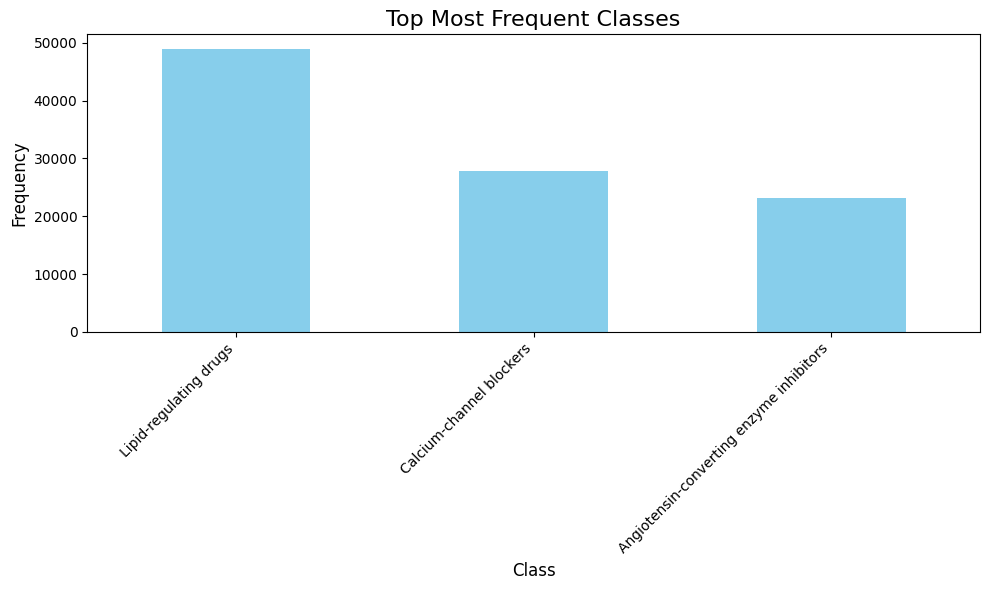

In [202]:
top_3_classes = get_top_n_classes(df, 'class', n=3)

print(top_3_classes.head())

plot_top_classes(top_3_classes)

In [203]:
clean_dose(df)

,order_id,person_id,medication_statement_id,concept_name,name,drug,dose,class,core_concept_id,concept,order_date,duration_days,order_enddate,statement_date,statement_enddate,medication_compliance,compliance_date,tablets_per_day
0,880093754,1169369,880093753,Product containing precisely ramipril 5 millig...,Product containing precisely ramipril 5 millig...,Ramipril,ONCE A DAY,Angiotensin-converting enzyme inhibitors,211873,211873,2016-08-24,0,2016-08-24,2016-08-24,2016-08-24,good,2025-01-21,NaN
1,448637151,569522,448636965,Product containing precisely simvastatin 20 mi...,Product containing precisely simvastatin 20 mi...,Simvastatin,1 TABLET ONCE NIGHTLY,Lipid-regulating drugs,212015,212015,2014-06-27,0,2014-06-27,2014-04-10,2014-09-05,good,2016-03-02,NaN
2,448637151,569522,448636965,Product containing precisely simvastatin 20 mi...,Product containing precisely simvastatin 20 mi...,Simvastatin,1 TABLET ONCE NIGHTLY,Lipid-regulating drugs,212015,212015,2014-06-27,0,2014-06-27,2014-04-10,2014-09-05,good,2021-07-06,NaN
3,448637073,569522,448636965,Product containing precisely simvastatin 20 mi...,Product containing precisely simvastatin 20 mi...,Simvastatin,1 TABLET ONCE NIGHTLY,Lipid-regulating drugs,212015,212015,2014-04-10,0,2014-04-10,2014-04-10,2014-09-05,good,2016-03-02,NaN
4,448637073,569522,448636965,Product containing precisely simvastatin 20 mi...,Product containing precisely simvastatin 20 mi...,Simvastatin,1 TABLET ONCE NIGHTLY,Lipid-regulating drugs,212015,212015,2014-04-10,0,2014-04-10,2014-04-10,2014-09-05,good,2021-07-06,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1017785508,1248786,1017785209,Lisinopril 20mg tablets,Lisinopril 20mg tablets,Lisinopril,one bd,Angiotensin-converting enzyme inhibitors,3145361,3145361,2016-07-03,56,2016-08-28,2016-05-06,2016-10-14,good,2024-01-29,2.0
99996,1017785508,1248786,1017785209,Lisinopril 20mg tablets,Lisinopril 20mg tablets,Lisinopril,one bd,Angiotensin-converting enzyme inhibitors,3145361,3145361,2016-07-03,56,2016-08-28,2016-05-06,2016-10-14,good,2024-08-12,2.0
99997,1017785475,1248786,1017785209,Lisinopril 20mg tablets,Lisinopril 20mg tablets,Lisinopril,one bd,Angiotensin-converting enzyme inhibitors,3145361,3145361,2016-08-24,56,2016-10-19,2016-05-06,2016-10-14,good,2025-03-06,2.0
99998,1017785475,1248786,1017785209,Lisinopril 20mg tablets,Lisinopril 20mg tablets,Lisinopril,one bd,Angiotensin-converting enzyme inhibitors,3145361,3145361,2016-08-24,56,2016-10-19,2016-05-06,2016-10-14,good,2024-01-29,2.0


Need to sort the clean dose code and add the duration days calculation into the pipe

In [ ]:
pdc_data = est_pdc(df, gap_threshold=120)
print(pdc_data.head)



<bound method NDFrame.head of        person_id                     drug  period_id period_start_date  \
0            173               Nifedipine          1        2009-02-09   
1            280               Lisinopril          1        2013-05-15   
2            293              Simvastatin          1        2009-01-07   
3            787  Diltiazem hydrochloride          1        2014-10-22   
4            990               Amlodipine          1        2001-12-31   
...          ...                      ...        ...               ...   
22109    6307775              Simvastatin          1        2001-09-10   
22110    6321521             Atorvastatin          1        2024-07-15   
22111    6358580                 Ramipril          1        2017-12-15   
22112    6378630               Amlodipine          1        2020-07-20   
22113    6461357              Simvastatin          1        2010-01-11   

      period_end_date  duration_period  order_gaps medication_compliance  \
0    

Add demographic data to the table

In [205]:
pdc_demo_data = add_demographic_data(snowsesh, pdc_data)

Merged data: 22114 rows with columns: ['person_id', 'drug', 'period_id', 'period_start_date', 'period_end_date', 'duration_period', 'order_gaps', 'medication_compliance', 'closest_compliance_date', 'duration_orders', 'est_pdc', 'start_of_month', 'end_of_month', 'practice_code', 'practice_name', 'registration_start_date', 'registration_end_date', 'include_in_list_size_flag', 'gender', 'ethnicity', 'ethnicity_detail', 'ethnicity_main_category', 'ethnic_aic_category', 'patient_lsoa_2011', 'patient_lsoa_2021', 'imd_decile', 'imd_quintile', 'date_of_death_pmi', 'date_of_death_dataset', 'uprn_suggests_lives_alone_flag', 'smoking_status', 'latest_smoking_status_date', 'ever_homeless_flag', 'housebound_flag', 'housebound_type', 'latest_housebound_code_date', 'obesity_flag', 'latest_bmi_date', 'bmi_value', 'total_ltcs', 'comorbidities', 'asthma', 'atrial_fibrillation', 'cancer', 'chronic_kidney_disease', 'copd', 'coronary_heart_disease', 'dementia', 'depression', 'diabetes', 'diabetes_type_1', 

In [206]:
print(pdc_demo_data.describe(include='all'))

           person_id          drug     period_id  \
count   2.211400e+04         22114  22114.000000   
unique           NaN            39           NaN   
top              NaN  Atorvastatin           NaN   
freq             NaN          5888           NaN   
mean    1.689579e+06           NaN     26.580673   
min     1.730000e+02           NaN      1.000000   
25%     7.108140e+05           NaN      2.000000   
50%     1.528715e+06           NaN     11.000000   
75%     2.463454e+06           NaN     30.000000   
max     6.461357e+06           NaN    320.000000   
std     1.194375e+06           NaN     42.139707   

                    period_start_date                period_end_date  \
count                           22114                          22114   
unique                            NaN                            NaN   
top                               NaN                            NaN   
freq                              NaN                            NaN   
mean    2015-06

In [207]:
get_table_one(pdc_demo_data,'medication_compliance')

                                                 Grouped by medication_compliance                                                               
                                                                          Missing        Overall        both           good         poor P-Value
n                                                                                          22114          15          19708         2391        
est_pdc, mean (SD)                                                           6573      1.0 (0.0)   1.0 (0.0)      1.0 (0.0)    1.0 (0.0)   0.070
gender, n (%)         Male                                                          10701 (48.4)  15 (100.0)    9654 (49.0)  1032 (43.2)  <0.001
                      Female                                                        10999 (49.7)                9761 (49.5)  1238 (51.8)        
                      None                                                             414 (1.9)                  293 (1.5)    121